<a href="https://colab.research.google.com/github/JacksonLeb/SkimLit/blob/main/09_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-466961ee-5da5-1b41-dfd6-cb8ca4174ddf)


#Building NLP Model to make Reading Medical Abstracts Easier

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#Checking files in Pubmed_20k
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
#Getting filenames and 20k  dataset with numbers replaced with @
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"


In [5]:
#checking file names in target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

###preproess data

In [6]:
#Function to read in lines of target text file
def get_lines(filename):
  """
  Reads in a filename and returns the lines of text as a list

  Args:
    filename: a string ocintains the target filepath

  Returns:
    a list containing each line in the file
  """
  with open(filename, "r") as f:
    return f.readlines()
    

In [7]:
#reading in training liines
train_lines = get_lines(data_dir+"/train.txt")

In [8]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

#How the data will be formatted
[
    {'linenumber': 0,
     'target': 'BACKGROUND',
     'text': 'Emotional eating is associated with overeating and the development of obesity ',
     'total_lines': 11},
 
]

In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  takes in filename, reads it contents and sort through each line, extracting htisngs like the target label,
  the text of the sentence, how many sentences are in the current asbtract, etc
  """

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if(line.startswith("###")):
      #new id line
       abstract_id = line
       abstract_lines = ""
    elif(line.isspace()):
      #new line
       abstract_line_split = abstract_lines.splitlines()

       #Iterate through each line in a single abstract and count them at the same time
       for abstract_line_number, abstract_line in enumerate(abstract_line_split):
         line_data = {}
         target_text_split = abstract_line.split('\t')
         line_data["target"] = target_text_split[0]
         line_data["text"] = target_text_split[1].lower()
         line_data["line_number"] = abstract_line_number
         line_data["total_lines"] = len(abstract_line_split) - 1
         abstract_samples.append(line_data)
    else:
      abstract_lines += line
  
  return abstract_samples


In [11]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")

CPU times: user 457 ms, sys: 77.8 ms, total: 535 ms
Wall time: 552 ms


In [12]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [13]:
train_samples[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [16]:
val_df

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
...,...,...,...,...
30207,RESULTS,pruritus occurred more frequently with the act...,9,13
30208,RESULTS,three patients in the active-regimen group ( @...,10,13
30209,RESULTS,hemoglobin values of grade @ ( @ to < @ g per ...,11,13
30210,CONCLUSIONS,rates of response to a @-week interferon-free ...,12,13


In [17]:
test_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [18]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

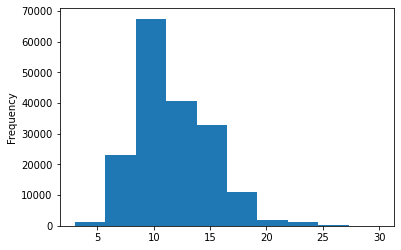

In [19]:
#length of different lines
train_df.total_lines.plot.hist()

In [20]:
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Making numeric lables (ML models require numbers)

In [21]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

In [22]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [23]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [26]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [27]:
#Model 0: Baseline Model - Naive Bayes TF-IDF Encoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#fitting the pipelien
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
#evaluate
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [29]:
#make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [30]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [31]:
##download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-07 15:48:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-07 15:48:51 (67.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [32]:
from helper_functions import calculate_results

In [33]:
baseline_results = calculate_results(val_labels_encoded,
                                   baseline_preds)

In [34]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing text for deep sequence models using tokenization and embedding

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [36]:
#How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [37]:
sent_lens

[49,
 27,
 15,
 14,
 35,
 29,
 30,
 55,
 36,
 8,
 32,
 39,
 12,
 26,
 33,
 40,
 22,
 23,
 27,
 26,
 27,
 34,
 41,
 18,
 9,
 23,
 59,
 16,
 18,
 22,
 17,
 51,
 8,
 17,
 16,
 5,
 21,
 4,
 42,
 50,
 11,
 19,
 20,
 29,
 36,
 44,
 39,
 25,
 19,
 24,
 19,
 14,
 11,
 18,
 16,
 26,
 16,
 18,
 38,
 28,
 21,
 18,
 22,
 9,
 37,
 6,
 32,
 21,
 26,
 25,
 18,
 21,
 20,
 12,
 26,
 16,
 23,
 19,
 16,
 39,
 19,
 14,
 37,
 34,
 15,
 47,
 26,
 87,
 17,
 29,
 31,
 13,
 37,
 28,
 35,
 60,
 64,
 66,
 8,
 12,
 17,
 40,
 43,
 37,
 47,
 6,
 40,
 64,
 20,
 32,
 53,
 16,
 30,
 54,
 51,
 19,
 28,
 32,
 36,
 40,
 13,
 25,
 30,
 23,
 17,
 15,
 20,
 50,
 12,
 16,
 27,
 24,
 10,
 24,
 5,
 14,
 19,
 32,
 13,
 21,
 23,
 10,
 11,
 17,
 12,
 21,
 21,
 15,
 17,
 21,
 18,
 40,
 33,
 21,
 41,
 21,
 13,
 29,
 28,
 13,
 44,
 20,
 31,
 8,
 29,
 13,
 116,
 27,
 26,
 32,
 34,
 17,
 23,
 20,
 29,
 11,
 7,
 17,
 31,
 43,
 36,
 17,
 31,
 17,
 42,
 18,
 39,
 29,
 30,
 24,
 81,
 19,
 19,
 33,
 22,
 11,
 55,
 11,
 14,
 28,
 42,
 34,
 

In [38]:
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([9.1130e+03, 3.2962e+04, 4.9105e+04, 3.4666e+04, 2.2517e+04,
        1.4360e+04, 6.8790e+03, 4.0660e+03, 2.5730e+03, 1.3580e+03,
        9.3400e+02, 5.1100e+02, 3.3600e+02, 2.2400e+02, 1.3100e+02,
        9.5000e+01, 6.8000e+01, 3.3000e+01, 2.5000e+01, 2.0000e+01,
        9.0000e+00, 1.1000e+01, 7.0000e+00, 5.0000e+00, 4.0000e+00,
        5.0000e+00, 5.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.   ,   8.375,  15.75 ,  23.125,  30.5  ,  37.875,  45.25 ,
         52.625,  60.   ,  67.375,  74.75 ,  82.125,  89.5  ,  96.875,
        104.25 , 111.625, 119.   , 126.375, 133.75 , 141.125, 148.5  ,
        155.875, 163.25 , 170.625, 178.   , 185.375, 192.75 , 200.125,
        207.5  , 214.875, 222.25 , 229.625, 237.   , 244.375, 251.75 ,
        259.125, 266.5  , 273.875, 281.25 , 288.625, 296.   ]),
 <a list of 40 Patch objects>)

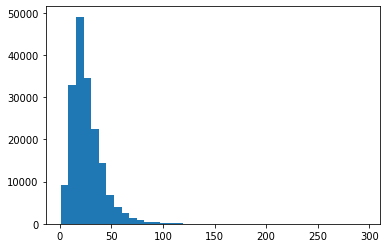

In [39]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=40)

In [40]:
np.percentile(sent_lens, .95)

4.0

In [41]:
output_seq_len = int(np.percentile(sent_lens, 95))

In [42]:
output_seq_len

55

In [43]:
max(sent_lens)

296

In [44]:
#Text Vectorization
#homw many words are in our vocabulary
max_tokens = 68000

In [45]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [46]:
#fitting text vectorizer to our data set
text_vectorizer.adapt(train_sentences)

In [47]:
#test out text_vectorizor on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text: {target_sentence}")
print(f"Vectorized Text: {text_vectorizer([target_sentence])}")

Text: these patients were followed-up for an extended one-year period .
Vectorized Text: [[ 111   12    9 4783   11   26 1774 3772  173    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [48]:
#HOw many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Num of words: {len(rct_20k_text_vocab)}")
print(f"most common words: {rct_20k_text_vocab[:5]}")
print(f"least common words: {rct_20k_text_vocab[-5:]}")

Num of words: 64841
most common words: ['', '[UNK]', 'the', 'and', 'of']
least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [49]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [50]:
#Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True, #using masking to handle vairable sequence lengths
                               name="token_embedding")

In [51]:
#show an example
print(f"sentence before embedding: {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"setnece after vectorization: {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"embedded sentence: {embedded_sentence}")
print(f"embedded sentence shape: {embedded_sentence.shape}")

sentence before embedding: these patients were followed-up for an extended one-year period .
setnece after vectorization: [[ 111   12    9 4783   11   26 1774 3772  173    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
embedded sentence: [[[-0.01722082 -0.04591778  0.0259194  ...  0.01596034 -0.0196112
   -0.01711954]
  [ 0.0177757  -0.04999868 -0.03735173 ...  0.04403848  0.00177372
    0.02925729]
  [-0.02096753 -0.03733854 -0.0119705  ... -0.01803531 -0.00405685
   -0.04726185]
  ...
  [-0.00841997  0.03683926 -0.03875958 ... -0.02187165 -0.01760768
    0.01824   ]
  [-0.00841997  0.03683926 -0.03875958 ... -0.02187165 -0.01760768
    0.01824   ]
  [-0.00841997  0.03683926 -0.03875958 ... -0.02187165 -0.01760768
    0.01824   ]]]
embedded sentence shape: (1, 55, 128)


In [52]:
## Creating datasets 
#Turn our data into tf datasets
train_labels_one_hot = tf.constant(train_labels_one_hot)
val_labels_one_hot = tf.constant(val_labels_one_hot)
test_labels_one_hot = tf.constant(test_labels_one_hot)

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [53]:
#Take the TensorSliceDataset into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [55]:
## Model 1: Conv1D with token embeddings
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)
#compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [56]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [57]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9336 - accuracy: 0.6297 - val_loss: 0.6994 - val_accuracy: 0.7329
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6581 - accuracy: 0.7577 - val_loss: 0.6352 - val_accuracy: 0.7704
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6151 - accuracy: 0.7758 - val_loss: 0.5958 - val_accuracy: 0.7816


In [58]:
#Evaluate on whole validation dtaset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5940 - accuracy: 0.7867


[0.5940498113632202, 0.7866741418838501]

In [59]:
#making predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [60]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)

In [61]:
model_1_results

{'accuracy': 78.66741692042896,
 'f1': 0.7839126937556534,
 'precision': 0.7832975576311368,
 'recall': 0.7866741692042897}

##Feature Extraction with pretrained token embeddings

In [62]:
#Using pretrained word embeddings from tensorflow hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [63]:
random_train_sentence = random.choice(train_sentences)
print(f"random sentence: {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"embedded version: {use_embedded_sentence}")

random sentence: patients were screened for depression , and the rate of depression diagnosis was compared with baseline .
embedded version: [[-1.4601629e-02 -5.8559339e-02  5.6295030e-02  2.4688045e-02
  -4.5602445e-02  6.5880045e-02  2.1370079e-02  1.8649932e-02
  -9.8604960e-03 -1.1492488e-02  8.6019762e-02  3.6621083e-02
  -4.5582909e-02  6.3981250e-02  6.0550798e-02 -8.2769915e-02
  -8.6074665e-02  6.8683095e-02 -5.9041653e-02  1.3420748e-02
  -5.1985964e-02  3.4329928e-02  8.5388143e-03  2.0060886e-02
   2.7658476e-02 -1.6225459e-02  1.0557277e-02  2.2665251e-02
   6.1836381e-02 -9.2655336e-03  2.1332251e-02  8.6087741e-02
   2.4621913e-02  8.3206641e-03 -5.4090810e-03 -3.1780990e-04
  -2.3821736e-02 -5.5480782e-02 -7.8491364e-03  5.6804274e-03
   2.0721698e-02  6.6510998e-02  1.3665102e-02  4.0729016e-02
   3.4083866e-02 -4.2583682e-02  6.8076216e-02  7.1684763e-02
   7.5287218e-03 -8.9647947e-05 -5.4065011e-02 -4.0650137e-02
   1.8696138e-03  4.7971290e-02  7.9190761e-02  3.579

#Building and Fitting a featuer extraction model


In [66]:
#model 2
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model2USEfeatureExtractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 26ms/step - loss: 0.9154 - accuracy: 0.6514 - val_loss: 0.7967 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7662 - accuracy: 0.7021 - val_loss: 0.7548 - val_accuracy: 0.7066
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7499 - accuracy: 0.7141 - val_loss: 0.7385 - val_accuracy: 0.7112


In [67]:
model_2.summary()

Model: "model2USEfeatureExtractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [68]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.7379 - accuracy: 0.7143


[0.7379451394081116, 0.7142857313156128]

In [71]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [73]:
#calcualte reults
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

In [74]:
model_2_results

{'accuracy': 71.42857142857143,
 'f1': 0.711431975697948,
 'precision': 0.7145982068076694,
 'recall': 0.7142857142857143}

In [75]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#Model_3 = Conv1D with Character Embeddings

###creating character level tokenization

In [76]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [77]:
def split_chars(text):
  return " ".join(list(text))

In [79]:
split_chars(random_train_sentence)

'p a t i e n t s   w e r e   s c r e e n e d   f o r   d e p r e s s i o n   ,   a n d   t h e   r a t e   o f   d e p r e s s i o n   d i a g n o s i s   w a s   c o m p a r e d   w i t h   b a s e l i n e   .'

In [80]:
#split sequence levle data into char level datset
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

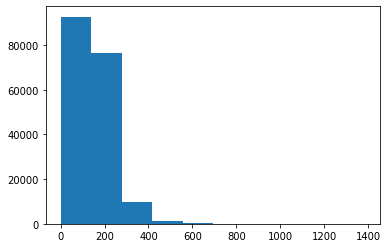

In [81]:
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=10)

In [83]:
#Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [95]:
#get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKENS = len(alphabet) + 2 #add 2 for space and UNK
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    #standardize=None,
                                    name="char_vectorizer")

In [96]:
#adapt character vectorizer to tarining characters
char_vectorizer.adapt(train_chars)

In [97]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Nmber of different character in charactervocab: {len(char_vocab)}")
print(f"most common chars : {char_vocab[:5]}")
print(f"Least common; {char_vocab[-5:]}")

Nmber of different character in charactervocab: 28
most common chars : ['', '[UNK]', 'e', 't', 'i']
Least common; ['k', 'x', 'z', 'q', 'j']


In [109]:
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"Length of ranodm_train_chares: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized Chars : {vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")


Charified text: 
 p o s t - r a c e   u r i n a r y   i l - @   ,   i l - @   a n d   i l - @ p @   c o n c e n t r a t i o n s   w e r e   s i g n i f i c a n t l y   l o w e r   i n   t h e   h b c d   t r i a l   c o m p a r e d   w i t h   t h e   g l u c o s e   t r i a l   (   p   <   @   )   ,   a l t h o u g h   t h e   p l a s m a   c o n c e n t r a t i o n s   o f   t h e s e   c y t o k i n e s   w e r e   n o t   s i g n i f i c a n t l y   d i f f e r e n t   b e t w e e n   b o t h   t r i a l s   .
Length of ranodm_train_chares: 211
Vectorized Chars : [[14  7  9  3  8  5 11  2 16  8  4  6  5  8 19  4 12  4 12  5  6 10  4 12
  14 11  7  6 11  2  6  3  8  5  3  4  7  6  9 20  2  8  2  9  4 18  6  4
  17  4 11  5  6  3 12 19 12  7 20  2  8  4  6  3 13  2 13 22 11 10  3  8
   4  5 12 11  7 15 14  5  8  2 10 20  4  3 13  3 13  2 18 12 16 11  7  9
   2  3  8  4  5 12 14  5 12  3 13  7 16 18 13  3 13  2 14 12  5  9 15  5
  11  7  6 11  2  6  3  8  5  3  4  7  6  9  7 17  3 13 

In [110]:
## creating a character level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [111]:
print(f"Charified text: \n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. : {char_embed_example}")
print(f"Embeddes shape: {char_embed_example.shape}")

Charified text: 
 p o s t - r a c e   u r i n a r y   i l - @   ,   i l - @   a n d   i l - @ p @   c o n c e n t r a t i o n s   w e r e   s i g n i f i c a n t l y   l o w e r   i n   t h e   h b c d   t r i a l   c o m p a r e d   w i t h   t h e   g l u c o s e   t r i a l   (   p   <   @   )   ,   a l t h o u g h   t h e   p l a s m a   c o n c e n t r a t i o n s   o f   t h e s e   c y t o k i n e s   w e r e   n o t   s i g n i f i c a n t l y   d i f f e r e n t   b e t w e e n   b o t h   t r i a l s   .
Embedded chars. : [[[ 0.01395837  0.0024062   0.02894903 ...  0.00501397  0.01051023
   -0.04980501]
  [-0.03067916 -0.00935898  0.006589   ... -0.01757188  0.01058234
    0.04243192]
  [ 0.01833098  0.02057642 -0.03812414 ... -0.00212409 -0.01261697
    0.01988454]
  ...
  [ 0.00538152 -0.01348241  0.00613593 ...  0.04035094  0.02561075
    0.02092501]
  [ 0.00538152 -0.01348241  0.00613593 ...  0.04035094  0.02561075
    0.02092501]
  [ 0.00538152 -0.01348241  0.00613593 ..

In [120]:
#model_3
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embedding")

In [121]:
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_8 (Dense)             (None, 5

In [122]:
#Create char level datsets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [123]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [124]:
#Fit the model on chars only
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 1.2656 - accuracy: 0.4703 - val_loss: 1.1329 - val_accuracy: 0.5293
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0963 - accuracy: 0.5491 - val_loss: 1.0278 - val_accuracy: 0.5881
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0073 - accuracy: 0.5969 - val_loss: 0.9545 - val_accuracy: 0.6190


In [128]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 1, ..., 4, 2, 0])>

In [130]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 61.62121011518602,
 'f1': 0.6067299352929058,
 'precision': 0.6312955266206725,
 'recall': 0.6162121011518602}